In [1]:
import os
import pandas as pd
import numpy as np
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords
import sklearn.model_selection as model_selection
from keras.datasets import imdb
from keras.preprocessing import sequence
from keras.layers import Dense
from keras.models import Sequential
from keras.layers import Embedding, SimpleRNN
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from keras.layers import LSTM
from keras.layers import Dropout
from keras.optimizers import SGD, RMSprop
from numpy import newaxis
import keras
from keras import backend as K
from sklearn.metrics import classification_report
import tensorflow as tf
import io
from tensorflow.keras import layers
from keras.layers import GlobalAveragePooling1D, Conv1D, Conv2D
import re
from sklearn.utils import shuffle

Using TensorFlow backend.


In [2]:
from numpy import array
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.embeddings import Embedding

In [3]:
import nltk
import os
import pandas as pd
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Vishaal\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Vishaal\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Vishaal\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [4]:
os.chdir('../10_Data/30_Balanced Tweets (Crit = High = Medium = Low)/10_2018 Train')

In [5]:
os.getcwd()

'C:\\Users\\Vishaal\\Documents\\GitHub\\TREC_Distributed_Machine_Learning\\TREC\\10_Data\\30_Balanced Tweets (Crit = High = Medium = Low)\\10_2018 Train'

In [6]:
'''
    Loading Balanced earthquake and flood data from 2018 train. 
'''
df_e1 = pd.read_csv('earthquake_TREC_2018_train_BALANCED.csv')
df_f1 = pd.read_csv('flood_TREC_2018_train_BALANCED.csv')

In [7]:
os.chdir('../15_2018 Test')

In [8]:
'''
    Loading our test 2018 tweets from eathquakes and floods separately. These have a decent amount of critical tweets.
    We did not include attacks as a considerable amount of work has been done on that before.
'''
df_e2 = pd.read_csv('earthquake_TREC_2018_test_BALANCED.csv')
df_f2 = pd.read_csv('flood_TREC_2018_test_BALANCED.csv')

In [9]:
'''
    Combining all earthquake tweets into one
'''
df_quake = pd.DataFrame()
df_quake['Tweet'] = pd.concat([df_e1['Tweet'] , df_e2['Tweet']])
df_quake['Priority'] = pd.concat([df_e1['Priority'] , df_e2['Priority']])

In [10]:
'''
    Combining all flood tweets into one
'''
df_flood = pd.DataFrame()
df_flood['Tweet'] = pd.concat([df_f1['Tweet'] , df_f2['Tweet']])
df_flood['Priority'] = pd.concat([df_f1['Priority'] , df_f2['Priority']])

In [11]:
'''
    Breaking up earthquake and flood tweets into low, med and high
'''
df_q_l = df_quake[(df_quake['Priority'] == 'Low') | (df_quake['Priority'] == 'Critical')]
df_q_m = df_quake[(df_quake['Priority'] == 'Medium') | (df_quake['Priority'] == 'Critical')]
df_q_h = df_quake[(df_quake['Priority'] == 'High') | (df_quake['Priority'] == 'Critical')]

df_f_l = df_flood[(df_flood['Priority'] == 'Low') | (df_flood['Priority'] == 'Critical')]
df_f_m = df_flood[(df_flood['Priority'] == 'Medium') | (df_flood['Priority'] == 'Critical')]
df_f_h = df_flood[(df_flood['Priority'] == 'High') | (df_flood['Priority'] == 'Critical')]

In [12]:
'''
Creating a categorical variable to keep label critical tweets as 1 and 0 otherwise
'''
def to_categorical(df_c):
    t = []
    for element in df_c['Priority']:
        if element =='Critical':
            t.append(1)
        else:
            t.append(0)
    return t
        
t_q_l = to_categorical(df_q_l)
t_q_m = to_categorical(df_q_m)
t_q_h = to_categorical(df_q_h)
t_f_l = to_categorical(df_f_l)
t_f_m = to_categorical(df_f_m)
t_f_h = to_categorical(df_f_h)

In [13]:
'''
    Shuffling dfs. CRITICAL TO MAKE IT LEARN...
'''
df_q_l, t_q_l = shuffle(df_q_l, t_q_l)
df_q_m, t_q_m = shuffle(df_q_m, t_q_m)
df_q_h, t_q_h = shuffle(df_q_h, t_q_h)

df_f_l, t_f_l = shuffle(df_f_l, t_f_l)
df_f_m, t_f_m = shuffle(df_f_m, t_f_m)
df_f_h, t_f_h = shuffle(df_f_h, t_f_h)

In [14]:
'''
    Creating a function to input lemmatized text to possibly another function that outputs the tfidf in a csv format.
    We could also simply use the output from this funtion in an tfidf format (no csv) and train a model.
'''
def preProcess(df):
    df['Tweet'] = df['Tweet'].astype('str')
    
    df['Tweet'] = df['Tweet'].apply(lambda x: re.split('https?://\S+', str(x))[0])
    
    token_array = []
    for tweet in df['Tweet']:
        token_tweet = word_tokenize(tweet)
        token_array.append(token_tweet)
        
    stop_words=set(stopwords.words("english"))
    filtered_token_array=[]
    for tweet in token_array:
        filtered_tweet = []
        for word in tweet:
                if word not in stop_words:
                    filtered_tweet.append(word)
        filtered_token_array.append(filtered_tweet)
        
    lem = WordNetLemmatizer()
    stem = PorterStemmer()

    lemmatized_array=[]
    for tweet in filtered_token_array:
        lemmatized_tweet = []
        for word in tweet:
            lemmatized_tweet.append(lem.lemmatize(word,'v'))
        lemmatized_array.append(lemmatized_tweet)
    
    lemmatized_array_join = []
    for element in lemmatized_array:
        lemmatized_array_join.append(' '.join(element))
        
    return (lemmatized_array_join)


In [15]:
'''
  We tokenize the lemmatized tweets to then do word embeddings
'''
l = preProcess(df_q_l)

all_words = []

for tweet in l:
    tokenize_word = word_tokenize(tweet)
    for word in tokenize_word:
        all_words.append(word)
'''
    Getting the unique words out
'''
unique_words = set(all_words)

In [16]:
'''
    Getting embedded sentences
'''
vocab_length = len(unique_words)

embedded_sentences = [one_hot(tweet, vocab_length) for tweet in l]

In [17]:
'''
    Making the size of all embeddings equal to the longest one
'''
word_count = lambda sentence: len(word_tokenize(sentence))
longest_sentence = max(l, key=word_count)
length_long_sentence = len(word_tokenize(longest_sentence))
padded_sentences = pad_sequences(embedded_sentences, length_long_sentence, padding='post')

In [30]:
padded_sentences.shape

(50, 34)

In [19]:
vocab_length

387

In [31]:
length_long_sentence 

34

In [72]:
iterations = 1

for i in range (iterations):
   
    l = preProcess(df_f_h)
    all_words = []
    for tweet in l:
        tokenize_word = word_tokenize(tweet)
        for word in tokenize_word:
            all_words.append(word)
    '''
        Getting the unique words out
    '''
    unique_words = set(all_words)

    '''
        Getting embedded sentences
    '''
    vocab_length = len(unique_words)
    embedded_sentences = [one_hot(tweet, vocab_length) for tweet in l]

    '''
        Making the size of all embeddings equal to the longest one
    '''
    word_count = lambda sentence: len(word_tokenize(sentence))
    longest_sentence = max(l, key=word_count)
    length_long_sentence = len(word_tokenize(longest_sentence))
    padded_sentences = pad_sequences(embedded_sentences, length_long_sentence, padding='post')

    '''
        Model Paramters
    '''
    model = keras.Sequential()
    model.add(Embedding(vocab_length, 100, input_length=padded_sentences.shape[1]))
    model.add(LSTM(128, input_shape = (padded_sentences.shape[1], 1), dropout=0.2, return_sequences=True))
    model.add(LSTM(64, return_sequences = True))
    model.add(LSTM(32, return_sequences = True))
    model.add(LSTM(16, return_sequences = True))
    model.add(GlobalAveragePooling1D())
    model.add(Dense(8, activation = 'relu', input_shape = (padded_sentences.shape[1],)))
    #model.add(Dropout(0.5))
    model.add(Dense(1, activation = 'sigmoid'))

    '''
        Compile and fit model
    '''
    model.compile(optimizer=keras.optimizers.RMSprop(lr = 0.0001),
                  loss='binary_crossentropy',
                  metrics=['acc', keras.metrics.Precision(), keras.metrics.Recall(), keras.metrics.AUC()])

    history = model.fit(padded_sentences, t_f_h, batch_size=4, epochs=50, validation_split=0.3, shuffle = True)

C:\Users\Vishaal\Anaconda3_Mod\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 42 samples, validate on 18 samples
Epoch 1/50
42/42 [==============================] - 2s 40ms/step - loss: 0.6934 - acc: 0.4762 - precision_13: 0.2500 - recall_13: 0.0500 - auc_13: 0.4750 - val_loss: 0.6934 - val_acc: 0.4444 - val_precision_13: 0.0000e+00 - val_recall_13: 0.0000e+00 - val_auc_13: 0.5000
Epoch 2/50
42/42 [==============================] - 1s 13ms/step - loss: 0.6927 - acc: 0.5238 - precision_13: 0.0000e+00 - recall_13: 0.0000e+00 - auc_13: 0.5000 - val_loss: 0.6937 - val_acc: 0.4444 - val_precision_13: 0.0000e+00 - val_recall_13: 0.0000e+00 - val_auc_13: 0.4750
Epoch 3/50
42/42 [==============================] - 1s 13ms/step - loss: 0.6927 - acc: 0.5238 - precision_13: 0.0000e+00 - recall_13: 0.0000e+00 - auc_13: 0.5795 - val_loss: 0.6939 - val_acc: 0.4444 - val_precision_13: 0.0000e+00 - val_recall_13: 0.0000e+00 - val_auc_13: 0.4000
Epoch 4/50
42/42 [==============================] - 0s 11ms/step - loss: 0.6924 - acc: 0.5238 - precision_13: 0.0000e+00 - reca

Epoch 31/50
42/42 [==============================] - 1s 13ms/step - loss: 0.2929 - acc: 1.0000 - precision_13: 1.0000 - recall_13: 1.0000 - auc_13: 1.0000 - val_loss: 0.7808 - val_acc: 0.5556 - val_precision_13: 0.6000 - val_recall_13: 0.6000 - val_auc_13: 0.6500
Epoch 32/50
42/42 [==============================] - 1s 14ms/step - loss: 0.2764 - acc: 1.0000 - precision_13: 1.0000 - recall_13: 1.0000 - auc_13: 1.0000 - val_loss: 0.7789 - val_acc: 0.5556 - val_precision_13: 0.6000 - val_recall_13: 0.6000 - val_auc_13: 0.6750
Epoch 33/50
42/42 [==============================] - 1s 15ms/step - loss: 0.2622 - acc: 1.0000 - precision_13: 1.0000 - recall_13: 1.0000 - auc_13: 1.0000 - val_loss: 0.7864 - val_acc: 0.5556 - val_precision_13: 0.6000 - val_recall_13: 0.6000 - val_auc_13: 0.6562
Epoch 34/50
42/42 [==============================] - 1s 15ms/step - loss: 0.2466 - acc: 1.0000 - precision_13: 1.0000 - recall_13: 1.0000 - auc_13: 1.0000 - val_loss: 0.7822 - val_acc: 0.5556 - val_precision_

In [73]:
model.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_13 (Embedding)     (None, 31, 100)           55000     
_________________________________________________________________
lstm_49 (LSTM)               (None, 31, 128)           117248    
_________________________________________________________________
lstm_50 (LSTM)               (None, 31, 64)            49408     
_________________________________________________________________
lstm_51 (LSTM)               (None, 31, 32)            12416     
_________________________________________________________________
lstm_52 (LSTM)               (None, 31, 16)            3136      
_________________________________________________________________
global_average_pooling1d_13  (None, 16)                0         
_________________________________________________________________
dense_25 (Dense)             (None, 8)               

In [74]:
embeddings = model.layers[0].get_weights()[0]

word_embeddings = {}

unique_words = list(unique_words)
for i in range(len(unique_words)):
    word_embeddings[unique_words[i]] = embeddings[i]

In [75]:
wrds = word_embeddings.keys()
vecs = word_embeddings.values()

In [76]:
df_embed = pd.DataFrame()
df_embed['Words'] = wrds
df_embed['Vectors'] = vecs
df_embed.to_csv('Keras_Flood_High_Embeddings.csv')

In [77]:
os.getcwd()

'C:\\Users\\Vishaal\\Documents\\GitHub\\TREC_Distributed_Machine_Learning\\TREC\\10_Data\\30_Balanced Tweets (Crit = High = Medium = Low)\\15_2018 Test'

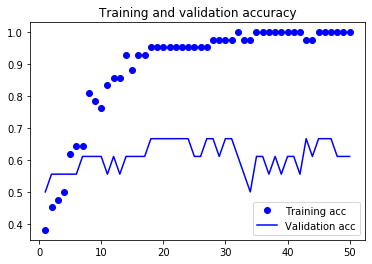

In [53]:
'''
    Plotting accuracy VS epoch for training and validations
'''
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

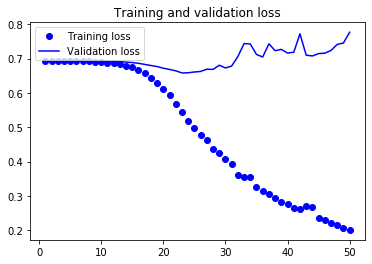

In [54]:

'''
    Plotting loss VS epoch for training and validations
'''
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

In [650]:
import statistics
precision = [0.9231, 0.5625, 0.4545, 1, 0.5455, 0.5556, 0.75, 1, 1, 0.4318]
recall = [1, 0.3, 0.4848, 1, 1, 1, 0.2273,1, 1, 0.9524]
AUC = [0.7821, 0.8427, 0.8946, 0.8002, 0.8383, 0.8453,0.8874, 0.8, 0.8062, 0.7847 ]
print('Mean Precision = ', statistics.mean(precision))
print('Stdev Precision = ', statistics.stdev(precision))
print('Mean Recall = ', statistics.mean(recall))
print('Stdev Recall = ', statistics.stdev(recall))
print('Mean ROC AUC = ', statistics.mean(AUC))
print('Stdev ROC AUC = ', statistics.stdev(AUC))

Mean Precision =  0.7223
Stdev Precision =  0.23877699033012187
Mean Recall =  0.79645
Stdev Recall =  0.3232536095871338
Mean ROC AUC =  0.82815
Stdev ROC AUC =  0.04027536467867174


In [49]:
y_pred = model.predict(history.validation_data[0])
y_pred

array([[0.6609599],
       [0.6609599],
       [0.6609599],
       [0.6609599],
       [0.6609599],
       [0.6609599],
       [0.6609599],
       [0.6609599],
       [0.6609599],
       [0.6609599],
       [0.6609599],
       [0.6609599],
       [0.6609599],
       [0.6609599],
       [0.6609599]], dtype=float32)

In [57]:
padded_sentences[34]

array([201, 386,   3, 186, 159,  94, 201,  52,  24, 287, 268, 150,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0])

In [35]:
len(padded_sentences[1])

34

In [59]:
history.validation_data

[array([[361,  95, 201,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0],
        [290, 181, 201, 229,  74, 244, 354, 367, 201, 290, 181, 201, 229,
          74, 244, 354,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0],
        [152, 266, 382, 278, 121, 164,  12,  22, 354, 197, 345, 288,  22,
          95, 384, 180, 384, 257,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0],
        [119, 189,  93,  48, 146,  23,  87, 220, 284, 187, 303,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0],
        [272, 242, 141,  24,  17, 298, 158, 380, 378, 149,  71, 287, 310,
         125, 103,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0],
        [ 

In [60]:
t_q_l

[1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0]